In [1]:
!pip install -U scikit-learn
!pip install autograd

## Preliminary: the softmax function

The softmax function plays a crucial role in neural networks, particularly in the output layer of classification models. Its primary purpose is to convert a vector of real numbers into a probability distribution over multiple classes. 

$$\text{Softmax}(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K
 $$

First, each element of the input vector is exponentiated (raised to the power of $e$), which makes all values positive.  The exponentiation step amplifies the differences between the input values. Larger values get significantly larger, and smaller values remain relatively small. This emphasizes the model's confidence in its predictions.

After exponentiation, the softmax function normalizes the values by dividing each exponentiated value by the sum of all exponentiated values in the input vector. This step ensures that the output vector sums up to 1, making it a valid probability distribution.

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the following 2-class dataset:

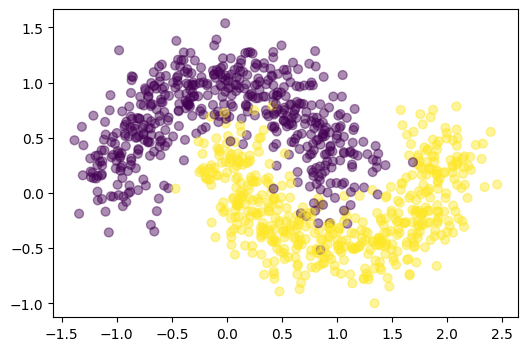

In [1]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

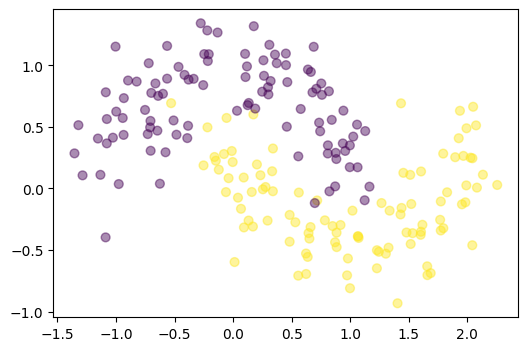

In [9]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45)

In [4]:
X[1], X.shape

(array([1.80460944, 0.00695963]), (1000, 2))

In [5]:
y[1], y.shape

(1, (1000,))

## Classification

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

+ The number of nodes in the input layer will be determined by the dimensionality of our data (2). 
+ Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ \hat{y} = \text{Softmax}({z_2})$$

where $\hat{y}$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 


## Cross-entropy loss

A common choice with the softmax output is the **cross-entropy loss**. 

If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [2]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality---> because the classificazion is either 1 or 0
sigma = np.tanh # activation function


# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

In [8]:
print(num_examples)

1000


In [3]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    #L'istruzione probs[range(num_examples), y] seleziona le probabilità corrispondenti alle etichette reali per ciascun esempio nel tuo dataset. 
    # In altre parole, per ogni esempio i, seleziona la probabilità prevista dal modello per la classe y[i].
    #Non moltiplichiamo per y perché vale 0 oppure 1.
    
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

#Questa linea restituisce l'indice della classe con la probabilità più alta per ciascun esempio. In altre parole, restituisce la classe predetta 
# per ciascun input in base alle probabilità calcolate.

In [6]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

#Questa operazione è comune nell'ottimizzazione dei modelli di machine learning, poiché consente di rappresentare i gradienti dei parametri del modello come un unico vettore,
#  che può poi essere utilizzato con algoritmi di ottimizzazione come la discesa del gradiente.
#In sintesi, queste due linee di codice stanno aiutando a convertire il modello e i gradienti associati in formati più adatti per l'ottimizzazione numerica, 
# semplificando la manipolazione dei pesi del modello e dei gradienti durante il processo di addestramento o di ottimizzazione del modello.



Loss after iteration 0: 0.578993
Loss after iteration 1000: 0.318070
Loss after iteration 2000: 0.297688
Loss after iteration 3000: 0.292829
Loss after iteration 4000: 0.289559
Loss after iteration 5000: 0.286088
Loss after iteration 6000: 0.281947
Loss after iteration 7000: 0.276860
Loss after iteration 8000: 0.270635
Loss after iteration 9000: 0.263206
Loss after iteration 10000: 0.254674
Loss after iteration 11000: 0.245306
Loss after iteration 12000: 0.235476
Loss after iteration 13000: 0.225571
Loss after iteration 14000: 0.215925
Loss after iteration 15000: 0.206780
Loss after iteration 16000: 0.198287
Loss after iteration 17000: 0.190518
Loss after iteration 18000: 0.183483
Loss after iteration 19000: 0.177156
Loss after iteration 20000: 0.171486
Loss after iteration 21000: 0.166413
Loss after iteration 22000: 0.161872
Loss after iteration 23000: 0.157801
Loss after iteration 24000: 0.154141
Loss after iteration 25000: 0.150836
Loss after iteration 26000: 0.147835
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

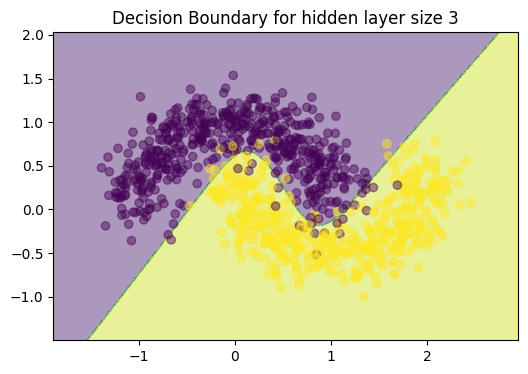

In [7]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    #Questa funzione è utile in situazioni in cui hai bisogno di trattare un array multidimensionale come una sequenza lineare di dati
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)
    #Quando contourf() viene chiamato con questi argomenti, disegna il grafico dei contorni sopra la griglia bidimensionale (xx, yy) utilizzando i valori Z per
    #  determinare le curve di contorno e colorando le aree interne alle curve

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

+ Report the classification accuracy using the testing dataset.

In [10]:
from sklearn.metrics import accuracy_score
#Now Xt and yt are our testing set
predictions = predict(model, Xt) #we compute the prediction using our model on the test data Xt
accuracy = accuracy_score(yt, predictions)
print("The accuracy for the model is:", accuracy) #we print the accuracy of our model using yt and predictions

#The accuracy is 0.955


The accuracy for the model is: 0.955


# Exercise 2

+ Add an additional layer to your neural network model. 
+ Change the activation function and use a ReLU. 


In [12]:
#First of all we define the ReLU function


def relu(x):
    return np.maximum(0, x)

def loss_2(model2):
    W1, b1, W2, b2, W3, b3 = model2['W1'], model2['b1'], model2['W2'], model2['b2'], model2['W3'], model2['b3']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    a2=relu(z2)
    z3=np.dot(a2,W3)+b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

def predict_2(model2, x):
    W1, b1, W2, b2, W3, b3 = model2['W1'], model2['b1'], model2['W2'], model2['b2'], model2['W3'], model2['b3']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    a2=relu(z2)
    z3=np.dot(a2,W3)+b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)


def build_model2(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model2 = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2,'W3': W3, 'b3': b3}
    
    for i in range(0, num_passes):

        predict_2(model2, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss_2)

        model_flat, unflatten_m = flatten(model2)
        grad_flat, unflatten_g = flatten(gradient_loss(model2))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model2 = unflatten_m(model_flat)

        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss_2(model2)))
    
    return model2


model2 = build_model2(3, print_loss=True)

###I JUST ADDED THE LAYER USING THE RELU FUNCTION AS ACTIVATING FUNCTION AND THEN ADDED W3,B3 AND ADJUSTED THE SYNTAX CHANGING FROM MODEL TO MODEL 2

#NOW WE ARE READY TO PREDICT:

predictions_2 = predict_2(model2, Xt) #we compute the prediction using our model on the test data Xt
accuracy_2 = accuracy_score(yt, predictions_2)
print("The accuracy for the model2 with another layer is:", accuracy_2) #we print the accuracy of our model using yt and predictions






Loss after iteration 0: 0.627848
Loss after iteration 1000: 0.308853
Loss after iteration 2000: 0.294556
Loss after iteration 3000: 0.289219
Loss after iteration 4000: 0.284340
Loss after iteration 5000: 0.280490
Loss after iteration 6000: 0.277045
Loss after iteration 7000: 0.273909
Loss after iteration 8000: 0.270762
Loss after iteration 9000: 0.267577
Loss after iteration 10000: 0.263987
Loss after iteration 11000: 0.259350
Loss after iteration 12000: 0.253370
Loss after iteration 13000: 0.245940
Loss after iteration 14000: 0.236082
Loss after iteration 15000: 0.222090
Loss after iteration 16000: 0.203517
Loss after iteration 17000: 0.182825
Loss after iteration 18000: 0.162738
Loss after iteration 19000: 0.145012
Loss after iteration 20000: 0.130503
Loss after iteration 21000: 0.120366
Loss after iteration 22000: 0.113618
Loss after iteration 23000: 0.109017
Loss after iteration 24000: 0.105633
Loss after iteration 25000: 0.102930
Loss after iteration 26000: 0.100662
Loss after ite

# Exercise 3

+ Design your own model (layers, activation function, number of units per layer, etc.) and train it to classify the following dataset. 
+ Train the model and report the classification accuracy using the testing dataset.


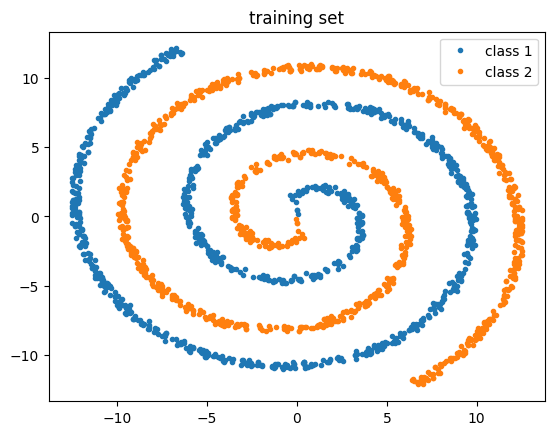

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

# combina le coordinate x e y dei punti delle due classi, mentre hstack 
#crea un vettore di etichette di classe, dove la prima metà dei punti appartiene alla classe 0 (etichettata con 0) e la seconda metà appartiene alla classe 1 (etichettata con 1).


X, y = twospirals(1000)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [3]:
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten
from sklearn.metrics import accuracy_score

#I HAVE REDIFINED ALL THE VARIABLES BECAUSE I RESTARTED THE KERNEL

X.shape #---> (2000,2)
y.shape #---> (2000) and here we have the labels for each point in X
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality---> because the classificazion is either 1 or 0
sigma = np.tanh # activation function
epsilon=0.01
n_layers=10
nn_hdim=16

y = y.astype(int)


#BUILD 3 LAYER WITH SIGMOID FUNCTION AND USING 5 NN_HDIM

Xt, yt = twospirals(200) #TESTING SET


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

weights=[]

def parameters():
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    weights.append((W1,b1))
    for i in range(n_layers):
        W = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
        b = np.zeros((1, nn_hdim))
        weights.append((W,b))
    W = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b = np.zeros((1, nn_output_dim))
    weights.append((W,b))
    
    return weights

def forward(my_model,x):
    weights=my_model[:-1]
    for w,b in weights:
        x=relu(np.dot(x,w)+b)
    w,b=my_model[-1]
    z=np.dot(x,w)+b
    exp_scores = np.exp(z)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs

def my_loss(my_model):
    probs=forward(my_model,X)
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

def my_predict(my_model, x):
    probs=forward(my_model,x)
    return np.argmax(probs, axis=1)

def build_my_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. 
    
    my_model = parameters()
    
    for i in range(0, num_passes):

        my_predict(my_model, X)
       
        gradient_loss = grad(my_loss)

        model_flat, unflatten_m = flatten(my_model)
        grad_flat, unflatten_g = flatten(gradient_loss(my_model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        my_model = unflatten_m(model_flat)

        if print_loss and i % 2000 == 0:
            print("Loss after iteration %i: %f" %(i, my_loss(my_model)))
    
    return my_model

my_model = build_my_model(16, print_loss=True) #TRY WITH 5 NEURONS

Xt, yt = twospirals(200)

#Now Xt and yt are our testing set
my_predictions = my_predict(my_model, Xt) #we compute the prediction using our model on the test data Xt
my_accuracy = accuracy_score(yt, my_predictions)
print("The accuracy for the modified model is:", my_accuracy) #we print the accuracy of our model using yt and predictions

#I TRIED WITH DIFFERENT FUNCTIONS AS SIGMOIDS AND COMBINING THEM WITH RELU, BUT THE BEST CHOICE IS RELU. AT FIRST I TRIED WITH 2-3 LAYER AND 5/10 NEURONS BUT I HAD A BAD
#ACCURACY, THEN WITH MORE LAYER THE PROCESS GIVE BETTER RESULTS. 50000 ITERATIONS ARE NOT NECESSARY. 



Loss after iteration 0: 0.694467
Loss after iteration 2000: 0.658010
Loss after iteration 4000: 0.646472
Loss after iteration 6000: 0.634837
Loss after iteration 8000: 0.605390
Loss after iteration 10000: 0.536408
Loss after iteration 12000: 0.336776
Loss after iteration 14000: 0.012913
Loss after iteration 16000: 0.040822
Loss after iteration 18000: 0.005003
The accuracy for the modified model is: 0.99


Text(0.5, 1.0, 'Graphical results')

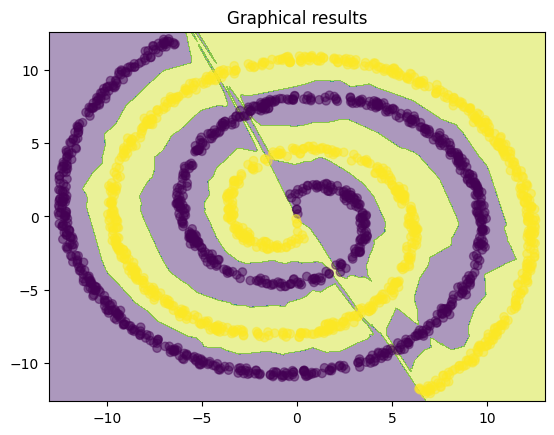

In [8]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    #Questa funzione è utile in situazioni in cui hai bisogno di trattare un array multidimensionale come una sequenza lineare di dati
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)
    #Quando contourf() viene chiamato con questi argomenti, disegna il grafico dei contorni sopra la griglia bidimensionale (xx, yy) utilizzando i valori Z per
    #  determinare le curve di contorno e colorando le aree interne alle curve

    
# Plot the decision boundary
plot_decision_boundary(lambda x: my_predict(my_model, x))
plt.title("Graphical results")